# Link Prediction using Similarity Features

Copyright @ 2020 **ABCOM Information Systems Pvt. Ltd.** All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.

See the License for the specific language governing permissions and limitations under the License.

## Continuation from where we left off in Part 2.

###Import required libraries

In [ ]:
import random
from tqdm import tqdm
import networkx as nx
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

###Download the required files.

In [ ]:
!wget https://github.com/abcom-mltutorials/Facebook-Social-Network-Analysis/archive/master.zip -P "/content"

ZipFile("/content/master.zip").extractall("/content/")

--2020-11-21 15:05:01--  https://github.com/ArkDy1312/Facebook-Social-Network-Analysis-Project/archive/master.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ArkDy1312/Facebook-Social-Network-Analysis-Project/zip/master [following]
--2020-11-21 15:05:01--  https://codeload.github.com/ArkDy1312/Facebook-Social-Network-Analysis-Project/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/master.zip’

master.zip              [   <=>              ]   1.35M  3.13MB/s    in 0.4s    

2020-11-21 15:05:01 (3.13 MB/s) - ‘/content/master.zip’ saved [1417240]



Retrieving the graph G and 'df1' dataframe from previous/Node2Vec part.

In [ ]:
G = nx.read_gpickle('/content/Facebook-Social-Network-Analysis-master/Graph.pickle')
df1 = pd.read_csv('/content/Facebook-Social-Network-Analysis-master/df1.csv', index_col=[0])

In [ ]:
#printing information about the graph
print(nx.info(G))

Name: Facebook SNA Graph
Type: Graph
Number of nodes: 1295
Number of edges: 18321
Average degree:  28.2950


In [ ]:
#printing the df1 dataframe
df1

,Node 1,Node 2,Connection
0,2,3,0
1,2,10,0
2,2,24,0
3,2,254,0
4,2,265,0
...,...,...,...
50586,3902,3926,1
50587,3902,3930,1
50588,3902,3938,1
50589,3926,3930,1


## Model Building

###Generating features from scratch

In [ ]:
#making a copy of the original dataframe
df_2 = df1.copy()

#sorting according to the nodes
df_2.sort_values(['Node 1', 'Node 2'], inplace=True)

#getting the two nodes in a row in a tuple, i.e (Node 1, Node 2) and adding then to a new Edges column
edges = [(df1.iloc[i,0],df1.iloc[i,1]) for i in range(df1.shape[0])]
df_2['Edges'] = edges

#dropping the Node 1 and Node 2 columns and setting the Edges column as index
df_2.drop(columns=df_2.columns[:2], inplace=True)
df_2.set_index('Edges', inplace=True)

df_2.head()

,Connection
Edges,
"(2, 3)",0
"(2, 10)",0
"(2, 24)",0
"(2, 254)",1
"(2, 265)",1


## Creating the features :

The features are created using the concepts of similarity measures. To understand the similarity measures in detail, check the documentation.

####Common Neighbors

In [ ]:
df_2['Common_Neigh'] = [len(list(nx.common_neighbors(G, e[0],e[1]))) for e in df_2.index]

####Jaccard Coefficient

In [ ]:
#creating a new temporary dataframe for storing the similarity measure values
df_3 = pd.DataFrame()

#finding jaccard coefficients
jaccard = list(nx.jaccard_coefficient(G, list(df_2.index)))

#storing the values in the new dataframe and setting the index as edges
df_3['Jaccard_Coef'] = [i[2] for i in jaccard]
df_3['Edges'] = [(i[0],i[1]) for i in jaccard]
df_3.set_index('Edges', inplace=True)

#merging the new dataframe with our previous 'df2' dataframe
df_2 = df_2.join(df_3, how='inner')

####Resource Allocation Index

In [ ]:
df_3 = pd.DataFrame()

#finding resource allocation index
resource_alloc = list(nx.resource_allocation_index(G, list(df_2.index)))

#storing the values in a new dataframe and setting the index as edges
df_3['Resource_Alloc'] = [i[2] for i in resource_alloc]
df_3['index'] = [(i[0],i[1]) for i in resource_alloc]
df_3.set_index('index', inplace=True)

#merging the new dataframe with our previous 'df2' dataframe
df_2 = df_2.join(df_3, how='inner')

####Adamic Adar Index

In [ ]:
df_3 = pd.DataFrame()

#finding adamic adar index
adamic_adar = list(nx.adamic_adar_index(G, list(df_2.index)))

#storing the values in a new dataframe and setting the index as edges
df_3['Adamic_Adar'] = [i[2] for i in adamic_adar]
df_3['index'] = [(i[0],i[1]) for i in adamic_adar]
df_3.set_index('index', inplace=True)

#merging the new dataframe with our previous 'df2' dataframe
df_2 = df_2.join(df_3, how='inner')

####Preferential Attachment

In [ ]:
df_3 = pd.DataFrame()

#finding preferential attachment
preferential_attach = list(nx.preferential_attachment(G, list(df_2.index)))

#storing the values in a new dataframe and setting the index as edges
df_3['Preferential_Attach'] = [i[2] for i in preferential_attach]
df_3['index'] = [(i[0],i[1]) for i in preferential_attach]
df_3.set_index('index', inplace=True)

#merging the new dataframe with our previous 'df2' dataframe
df_2 = df_2.join(df_3, how='inner')

####Community Common Neighbors

In [ ]:
df_3 = pd.DataFrame()

#finding community common neighbors, community is the 'location;id'
community_common_neigh = list(nx.cn_soundarajan_hopcroft(G,list(df_2.index), community='location;id'))

#storing the values in a new dataframe and setting the index as edges
df_3['Community_Comnon_Neigh'] = [i[2] for i in community_common_neigh]
df_3['index'] = [(i[0],i[1]) for i in community_common_neigh]
df_3.set_index('index', inplace=True)

#merging the new dataframe with our previous 'df2' dataframe
df_2 = df_2.join(df_3, how='inner')

####Community Resource Allocation Index

In [ ]:
df_3 = pd.DataFrame()

#finding community resource allocation index, community is the 'location;id'
community_resource_alloc = list(nx.ra_index_soundarajan_hopcroft(G,list(df_2.index), community='location;id'))

#storing the values in a new dataframe and setting the index as edges
df_3['Community_Resource_Alloc'] = [i[2] for i in community_resource_alloc]
df_3['index'] = [(i[0],i[1]) for i in community_resource_alloc]
df_3.set_index('index', inplace=True)

#merging the new dataframe with our previous 'df2' dataframe
df_2 = df_2.join(df_3, how='inner')

In [ ]:
#printing the first few rows of the dataframe

df_2.head()

,Connection,Common_Neigh,Jaccard_Coef,Resource_Alloc,Adamic_Adar,Preferential_Attach,Community_Comnon_Neigh,Community_Resource_Alloc
"(2, 3)",0,0,0.0,0.0,0.0,21,0,0.0
"(2, 10)",0,0,0.0,0.0,0.0,18,0,0.0
"(2, 24)",0,0,0.0,0.0,0.0,27,0,0.0
"(2, 254)",1,0,0.0,0.0,0.0,30,0,0.0
"(2, 265)",1,0,0.0,0.0,0.0,54,0,0.0


###Plotting the Correlation matrix of the dataframe ‘df_2’.

Text(0.5, 1.05, 'Pearson Correlation of Features')

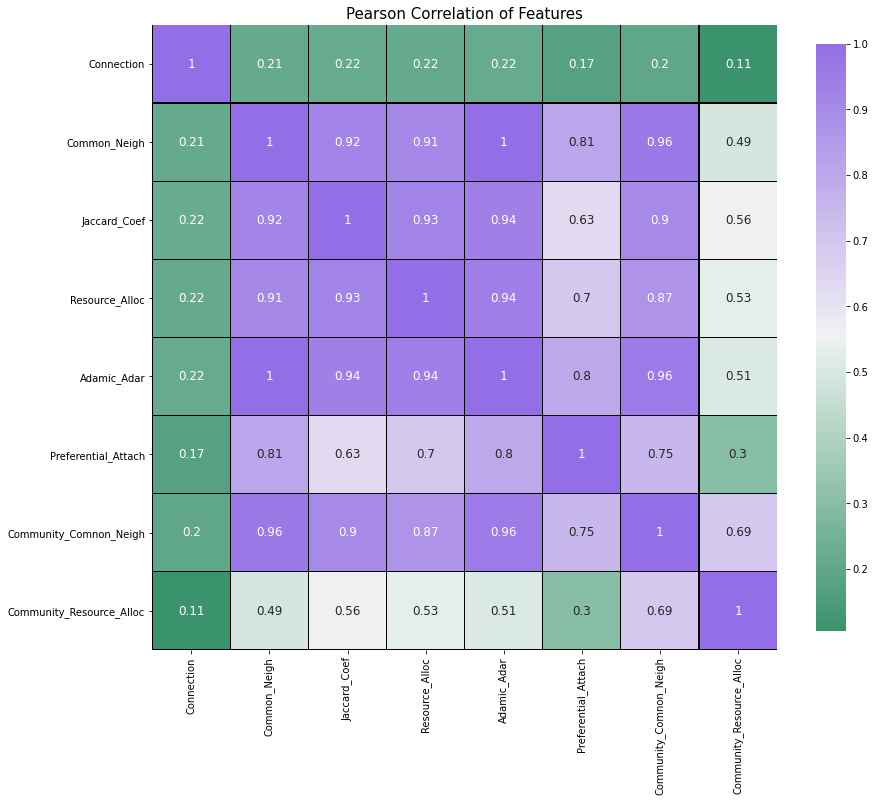

In [ ]:
#setting the figure
_ , ax = plt.subplots(figsize =(14, 12))

#setting the colormap
colormap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap = True)

#creating the heatmap
_ = sns.heatmap(df_2.corr(), cmap = colormap, square=True, cbar_kws={'shrink':.9 }, ax=ax, annot=True, 
                                                     linewidths=0.1,vmax=1.0, linecolor='black', annot_kws={'fontsize':12 })
    
#adding title
plt.title('Pearson Correlation of Features', y=1.05, size=15)

## Creating the Model :

####Importing the libraries and setting the features and target column as X and y respectively

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, roc_auc_score,confusion_matrix

X = df_2.iloc[:,1:]   
y = df_2['Connection']

####Splitting into train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

####Scaling the X_train and X_test values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#this will be used only for MLP Classifier
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We will create the model, the same way we have done before, by using GridSearchCV on different ML models to get the best one.


###Random Forest

In [ ]:
clf1 = RandomForestClassifier()

param = {'n_estimators' : [100,200,300], 'max_depth' : [5,10,15,20]}

grid_clf_acc1 = GridSearchCV(clf1, param_grid = param)
grid_clf_acc1.fit(X_train_scaled, y_train)

print('Grid best parameter (max. accuracy): ', grid_clf_acc1.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc1.best_score_)

# alternative metric to optimize over grid parameters: AUC
grid_clf_auc1 = GridSearchCV(clf1, param_grid = param, scoring = 'roc_auc')
grid_clf_auc1.fit(X_train, y_train)
predict_proba = grid_clf_auc1.predict_proba(X_test_scaled)

print('Test set AUC: ', roc_auc_score(y_test, predict_proba[:,1]))
print('Grid best parameter (max. AUC): ', grid_clf_auc1.best_params_)
print('Grid best score (AUC): ', grid_clf_auc1.best_score_)

Grid best parameter (max. accuracy):  {'max_depth': 10, 'n_estimators': 300}
Grid best score (accuracy):  0.6818651978944916
Test set AUC:  0.6290310438479708
Grid best parameter (max. AUC):  {'max_depth': 5, 'n_estimators': 200}
Grid best score (AUC):  0.6479362058124438


###Gradient Boost

In [ ]:
clf2 = GradientBoostingClassifier()

param = {'learning_rate' : [.01,.1]}

grid_clf_acc2 = GridSearchCV(clf2, param_grid = param)
grid_clf_acc2.fit(X_train, y_train)

print('Grid best parameter (max. accuracy): ', grid_clf_acc2.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc2.best_score_)

# alternative metric to optimize over grid parameters: AUC
grid_clf_auc2 = GridSearchCV(clf2, param_grid = param, scoring = 'roc_auc')
grid_clf_auc2.fit(X_train, y_train)
predict_proba = grid_clf_auc2.predict_proba(X_test)[:,1]

print('Test set AUC: ', roc_auc_score(y_test, predict_proba))
print('Grid best parameter (max. AUC): ', grid_clf_auc2.best_params_)
print('Grid best score (AUC): ', grid_clf_auc2.best_score_)

Grid best parameter (max. accuracy):  {'learning_rate': 0.1}
Grid best score (accuracy):  0.6798357783193818
Test set AUC:  0.6455341552023439
Grid best parameter (max. AUC):  {'learning_rate': 0.1}
Grid best score (AUC):  0.6481285620708953


###MLP Classifier 

In [ ]:
clf3 = MLPClassifier()

param = {'hidden_layer_sizes' : [10,100,[10,10]], 'activation' : ['tanh','relu'], 'solver' : ['adam','lbfgs']}

grid_clf_acc3 = GridSearchCV(clf3, param_grid = param)
grid_clf_acc3.fit(X_train_scaled, y_train)

print('Grid best parameter (max. accuracy): ', grid_clf_acc3.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc3.best_score_)

# alternative metric to optimize over grid parameters: AUC
grid_clf_auc3 = GridSearchCV(clf3, param_grid = param, scoring = 'roc_auc')
grid_clf_auc3.fit(X_train_scaled, y_train)
predict_proba = grid_clf_auc3.predict_proba(X_test_scaled)[:,1]

print('Test set AUC: ', roc_auc_score(y_test, predict_proba))
print('Grid best parameter (max. AUC): ', grid_clf_auc3.best_params_)
print('Grid best score (AUC): ', grid_clf_auc3.best_score_)

Grid best parameter (max. accuracy):  {'activation': 'relu', 'hidden_layer_sizes': [10, 10], 'solver': 'lbfgs'}
Grid best score (accuracy):  0.6793615012934197
Test set AUC:  0.6446991955419613
Grid best parameter (max. AUC):  {'activation': 'relu', 'hidden_layer_sizes': 100, 'solver': 'lbfgs'}
Grid best score (AUC):  0.649518504867021


## Choosing the best Model


Random Forest gives the best accuracy, hence using it as my final model.



In [ ]:
#getting predictions of our test data
pred = grid_clf_acc1.predict(X_test_scaled)

pred[:5]

array([0, 0, 0, 0, 0])

####Accuracy Score

In [ ]:
accuracy_score(pred,y_test)

0.6786053130929791

####Confusion Matrix

In [ ]:
confusion_matrix(pred,y_test)

array([[7303, 3042],
       [1023, 1280]])

###Getting the ROC_AUC Score and Plotting the Roc Curve

Text(0, 0.5, 'True Positive Rate')

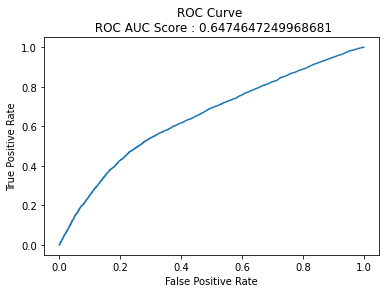

In [ ]:
predict_proba = grid_clf_acc1.predict_proba(X_test_scaled)[:,1]
false_positive_rate,true_positive_rate,_ = roc_curve(y_test, predict_proba)
roc_auc_score = auc(false_positive_rate,true_positive_rate)

plt.plot(false_positive_rate,true_positive_rate)
plt.title(f'ROC Curve \n ROC AUC Score : {roc_auc_score}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Demonstration

In [ ]:
df_2.head()

,Connection,Common_Neigh,Jaccard_Coef,Resource_Alloc,Adamic_Adar,Preferential_Attach,Community_Comnon_Neigh,Community_Resource_Alloc
"(2, 3)",0,0,0.0,0.0,0.0,21,0,0.0
"(2, 10)",0,0,0.0,0.0,0.0,18,0,0.0
"(2, 24)",0,0,0.0,0.0,0.0,27,0,0.0
"(2, 254)",1,0,0.0,0.0,0.0,30,0,0.0
"(2, 265)",1,0,0.0,0.0,0.0,54,0,0.0


In [ ]:
# from the above dataframe let's choose the nodes 2 and 24
# node pair (2,24) is at index 2, hence let's print it's features

print(f' ({df_2.index[2][0]},{df_2.index[2][1]}) node pair features : {X.iloc[2,:]}')

# its position in X_train
print(f'Index of ({df_2.index[2][0]},{df_2.index[2][1]}) node pair in X_train : {np.where(X_train.index == X.index[2])[0][0]}')

 (2,24) node pair features : Common_Neigh                 0.0
Jaccard_Coef                 0.0
Resource_Alloc               0.0
Adamic_Adar                  0.0
Preferential_Attach         27.0
Community_Comnon_Neigh       0.0
Community_Resource_Alloc     0.0
Name: (2, 24), dtype: float64
Index of (2,24) node pair in X_train : 22897


In [ ]:
# probability of the two nodes forming a link or edge
# we will be using the values from X_train_scaled since 
# we have used the scaled version to train our model
predict_proba = grid_clf_auc3.predict_proba(X_train_scaled[np.where(X_train.index == X.index[2])[0][0]].reshape(1,-1))[:,1]

print(f'Probability of nodes {df_2.index[2][0]} and {df_2.index[2][1]} to form a link is : {float(predict_proba)*100 : .2f}%')

Probability of nodes 2 and 24 to form a link is :  20.14%
